# Reading Data

In [ ]:
#Importing necessary packages

import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import math

In [ ]:
#Reading Data - acquired through The National Registry of Exonerations

wc = pd.read_csv("/content/drive/MyDrive/Data3000/Data3000 Project/WrongfulConvictions.csv")

In [ ]:
#Overview of wrongful convictions dataset

wc.head()

,Last Name,First Name,Age,Race,Sex,State,County,Tags,Worst Crime Display,Sentence,...,Posting Date,OM Tags,F/MFE,FC,ILD,P/FA,DNA,MWID,OM,Date of Crime Year
0,Abbitt,Joseph,31.0,Black,Male,North Carolina,Forsyth,CV;#IO;#SA,Child Sex Abuse,Life,...,9/1/11,NaN,NaN,NaN,NaN,NaN,DNA,MWID,NaN,"1,991"
1,Abbott,Cinque,19.0,Black,Male,Illinois,Cook,CIU;#IO;#NC;#P,Drug Possession or Sale,Probation,...,2/14/22,OF;#WH;#NW,NaN,NaN,NaN,P/FA,NaN,NaN,OM,"2,008"
2,Abdal,Warith Habib,43.0,Black,Male,New York,Erie,IO;#SA,Sexual Assault,20 to Life,...,8/29/11,OF;#WH;#NW;#WT,F/MFE,NaN,NaN,NaN,DNA,MWID,OM,"1,982"
3,Abernathy,Christopher,17.0,White,Male,Illinois,Cook,CIU;#CV;#H;#IO;#JV;#SA,Murder,Life without parole,...,2/13/15,OF;#WH;#NW;#INT,NaN,FC,NaN,P/FA,DNA,NaN,OM,"1,984"
4,Abney,Quentin,32.0,Black,Male,New York,New York,CV,Robbery,20 to Life,...,5/13/19,NaN,NaN,NaN,NaN,NaN,NaN,MWID,NaN,"2,005"


# Data Cleaning and Engineering

In [ ]:
#Transforming Contributing Factors to binary columns

wc["OM_Binary"] = wc["OM"].apply(lambda x: 1 if x == "OM" else 0)
wc["FC_Binary"] = wc["FC"].apply(lambda x: 1 if x == "FC" else 0)
wc["PFA_Binary"] = wc["P/FA"].apply(lambda x: 1 if x == "P/FA" else 0)
wc["MWID_Binary"] = wc["MWID"].apply(lambda x: 1 if x == "MWID" else 0)
wc["ILD_Binary"] = wc["ILD"].apply(lambda x: 1 if x == "ILD" else 0)
wc["FMFE_Binary"] = wc["F/MFE"].apply(lambda x: 1 if x == "F/MFE" else 0)

In [ ]:
#Switching Official Misconduct Tags to binary columns

wc["OM Tags Null"] = wc["OM Tags"].apply(lambda x: "0" if pd.isna(x) == True else x)
wc["OF"] = wc["OM Tags Null"].apply(lambda x: 1 if "OF" in x else 0)
wc["WH"] = wc["OM Tags Null"].apply(lambda x: 1 if "WH" in x else 0)
wc["NW"] = wc["OM Tags Null"].apply(lambda x: 1 if "NW" in x else 0)
wc["WT"] = wc["OM Tags Null"].apply(lambda x: 1 if "WT" in x else 0)
wc["IN"] = wc["OM Tags Null"].apply(lambda x: 1 if "INT" in x else 0)
wc["PR"] = wc["OM Tags Null"].apply(lambda x: 1 if "PR" in x else 0)
wc["FA"] = wc["OM Tags Null"].apply(lambda x: 1 if "INT" in x else 0)
wc["CW"] = wc["OM Tags Null"].apply(lambda x: 1 if "INT" in x else 0)
wc["KP"] = wc["OM Tags Null"].apply(lambda x: 1 if "INT" in x else 0)
wc["PJ"] = wc["OM Tags Null"].apply(lambda x: 1 if "INT" in x else 0)
wc["PL"] = wc["OM Tags Null"].apply(lambda x: 1 if "INT" in x else 0)

In [ ]:
#Creating target variable of Time_Spent_in_Prison by subtracting the year of conviction from the year of exoneration

wc["Time_Spent_In_Prison"] = wc["Exonerated"] - wc["Convicted"]

In [ ]:
#Dropping previous columns to make a clean dataframe

df = wc.drop(["F/MFE", "FC", "ILD", "P/FA", "MWID", "OM", "DNA", "OM Tags Null"], axis = 1)

In [ ]:
#Taking the natural log of Time_Spent_In_Prison to eliminate any skewness, put in a new column Time_Spent_In_Prison_log
#Adding .01 to eliminate the possibility of zero values

df["Time_Spent_In_Prison_log"] = df["Time_Spent_In_Prison"] + .01
df["Time_Spent_In_Prison_log"] = np.log(df["Time_Spent_In_Prison"])
df = df.replace([np.inf, -np.inf], np.nan)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
#Creating a function to extract the first number in the Sentence column, used to extract the relevant number of years
#Categorization is based on the first number in a sentence, for example: a sentence of 45-60 years would be taken as 45 years

def extract_first_number(sentence):
    import re
    match = re.match(r'\d+', sentence)
    if match:
        return int(match.group())
    else:
        return None

In [ ]:
#Creating a function to categorize the broad range of sentences in the original Sentence column
#For simplicity, there are 9 buckets: Death, Possible Life, More Than 40 Years, More Than 30 Years, More Than 20 Years, More Than 10 Years
# (Con't) Less Than 10 Years, Less Than 1 Year, and Other

def categorize_sentence(sentence):
    if "Life" in sentence:
        return "Possible Life"
    elif "years" in sentence:
        years = extract_first_number(sentence)
        if years > 40:
          return "More Than 40 Years"
        elif years > 30:
          return "More Than 30 Years"
        elif years > 20:
          return "More Than 20 Years"
        elif years > 10:
          return "More Than 10 Years"
        else:
          return "Less Than 10 Years"
    elif "year" in sentence or "months" in sentence or "days" in sentence:
        return "Less Than 1 Year"
    elif "Death" in sentence:
        return "Death"
    else:
        return "Other"

#Creating a new column Sentence_Category

df["Sentence_Category"] = df["Sentence"].apply(categorize_sentence)

In [ ]:
#Mapping the categories to a new numerical column Sentence_Category_Number

category_number = {
    "Death": 8,
    "Possible Life": 7,
    "More Than 40 Years": 6,
    "More Than 30 Years": 5,
    "More Than 20 Years": 4,
    "More Than 10 Years": 3,
    "Less Than 10 Years": 2,
    "Less Than 1 Year": 1,
    "Other" : 0
}

df['Sentence_Category_Number'] = df["Sentence_Category"].map(category_number)

In [ ]:
#Creating a new dataframe with the selected 9 features and 2 targets for the model

df_dnn = df[["Race", "Sex", "State", "OM_Binary", "PFA_Binary", "FC_Binary", "MWID_Binary", "ILD_Binary", "FMFE_Binary", "Time_Spent_In_Prison_log", "Sentence_Category_Number"]]
df_dnn.head()

,Race,Sex,State,OM_Binary,PFA_Binary,FC_Binary,MWID_Binary,ILD_Binary,FMFE_Binary,Time_Spent_In_Prison_log,Sentence_Category_Number
0,Black,Male,North Carolina,0,0,0,1,0,0,2.639057,7
1,Black,Male,Illinois,1,1,0,0,0,0,2.639057,0
2,Black,Male,New York,1,0,0,1,0,1,2.772589,7
3,White,Male,Illinois,1,1,1,0,0,0,3.332205,7
4,Black,Male,New York,0,0,0,1,0,0,1.791759,7


In [ ]:
#Dropping any missing data from the dataframe

df_dnn = df_dnn.dropna()

In [ ]:
#Replacing the textual values for State, Race, and Sex with numerical values

State_dummy = {val: idx for idx, val in enumerate(df_dnn["State"].unique())}
Race_dummy = {val: idx for idx, val in enumerate(df_dnn["Race"].unique())}
Sex_dummy = {val: idx for idx, val in enumerate(df_dnn["Sex"].unique())}

df_dnn["State"] = df_dnn["State"].replace(State_dummy)
df_dnn["Race"] = df_dnn["Race"].replace(Race_dummy)
df_dnn["Sex"] = df_dnn["Sex"].replace(Sex_dummy)

<ipython-input-138-e684ed898d01>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dnn["State"] = df_dnn["State"].replace(State_dummy)
<ipython-input-138-e684ed898d01>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dnn["Race"] = df_dnn["Race"].replace(Race_dummy)
<ipython-input-138-e684ed898d01>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

# Variable Visualizations (Time Spent In Prison)

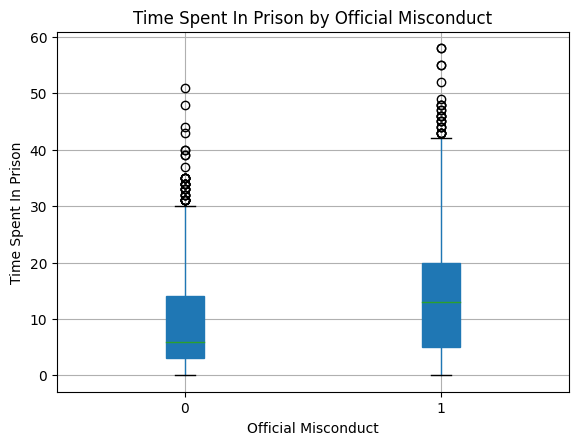

In [ ]:
#Visualizing the distribution of Time_Spent_In_Prison for levels of Official Misconduct
#Value of 0 means Official Misconduct did not occur in a case, value of 1 means that it did occur in a case

df.boxplot(column="Time_Spent_In_Prison", by="OM_Binary", patch_artist = True)
plt.title("Time Spent In Prison by Official Misconduct")
plt.xlabel("Official Misconduct")
plt.ylabel("Time Spent In Prison")
plt.suptitle('')
plt.show()

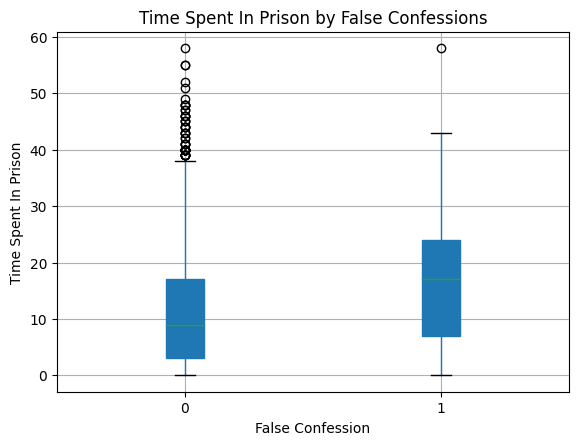

In [ ]:
#Visualizing the distribution of Time_Spent_In_Prison for levels of False Confession
#Value of 0 means a False Confession did not occur in a case, value of 1 means that it did occur in a case

df.boxplot(column="Time_Spent_In_Prison", by="FC_Binary", patch_artist = True)
plt.title("Time Spent In Prison by False Confessions")
plt.xlabel("False Confession")
plt.ylabel("Time Spent In Prison")
plt.suptitle('')
plt.show()

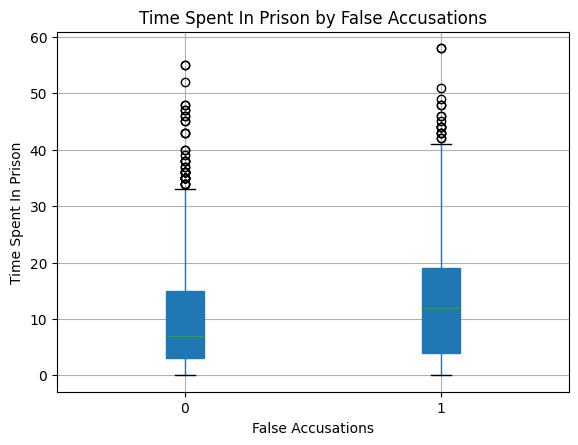

In [ ]:
#Visualizing the distribution of Time_Spent_In_Prison for levels of False Accusation
#Value of 0 means a False Accusation did not occur in a case, value of 1 means that it did occur in a case

df.boxplot(column="Time_Spent_In_Prison", by="PFA_Binary", patch_artist = True)
plt.title("Time Spent In Prison by False Accusations")
plt.xlabel("False Accusations")
plt.ylabel("Time Spent In Prison")
plt.suptitle('')
plt.show()

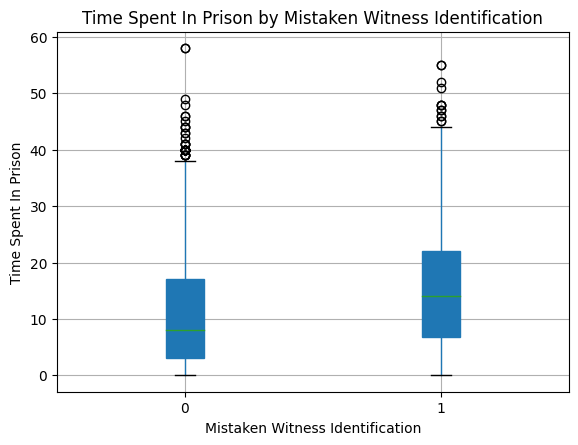

In [ ]:
#Visualizing the distribution of Time_Spent_In_Prison for levels of Mistaken Witness Identification
#Value of 0 means Mistaken Witness Identification did not occur in a case, value of 1 means that it did occur in a case

df.boxplot(column="Time_Spent_In_Prison", by="MWID_Binary", patch_artist = True)
plt.title("Time Spent In Prison by Mistaken Witness Identification")
plt.xlabel("Mistaken Witness Identification")
plt.ylabel("Time Spent In Prison")
plt.suptitle('')
plt.show()

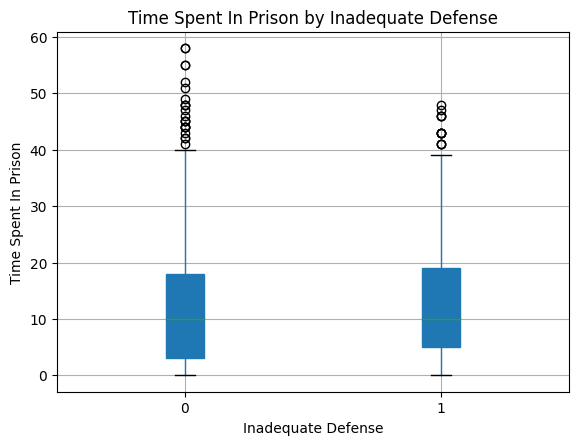

In [ ]:
#Visualizing the distribution of Time_Spent_In_Prison for levels of Inadequate Defense
#Value of 0 means Inadequate Defense did not occur in a case, value of 1 means that it did occur in a case

df.boxplot(column="Time_Spent_In_Prison", by="ILD_Binary", patch_artist = True)
plt.title("Time Spent In Prison by Inadequate Defense")
plt.xlabel("Inadequate Defense")
plt.ylabel("Time Spent In Prison")
plt.suptitle('')
plt.show()

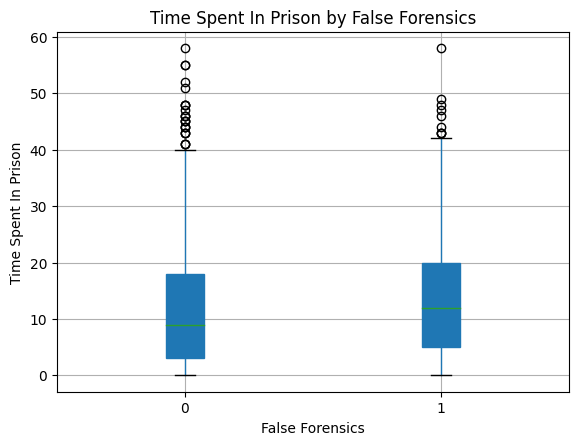

In [ ]:
#Visualizing the distribution of Time_Spent_In_Prison for levels of False Forensic Analysis
#Value of 0 means False Forensic Analysis did not occur in a case, value of 1 means that it did occur in a case

df.boxplot(column="Time_Spent_In_Prison", by="FMFE_Binary", patch_artist = True)
plt.title("Time Spent In Prison by False Forensics")
plt.xlabel("False Forensics")
plt.ylabel("Time Spent In Prison")
plt.suptitle('')
plt.show()

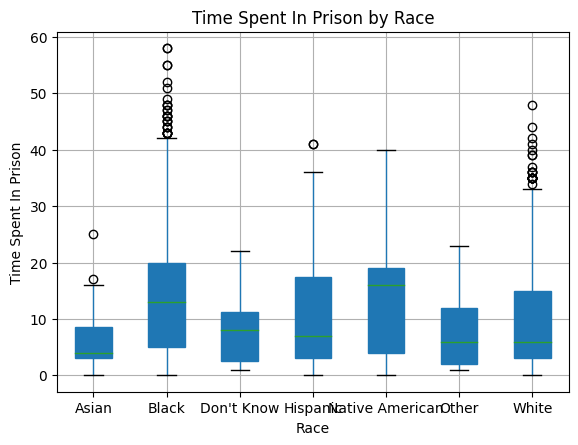

In [ ]:
#Visualizing the distribution of Time_Spent_In_Prison per Race

plt.title("Time Spent In Prison by Race")
plt.xlabel("Race")
plt.ylabel("Time Spent In Prison")
plt.suptitle('')
plt.show()

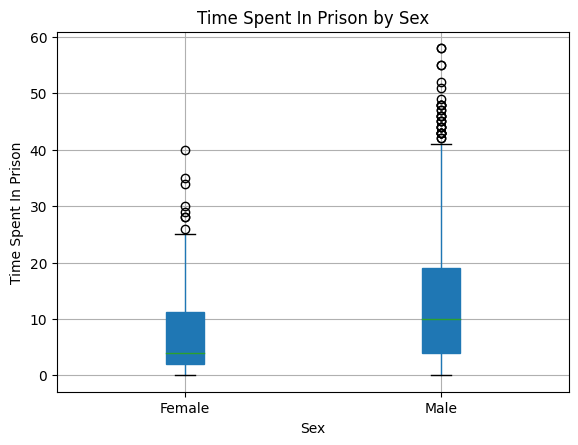

In [ ]:
#Visualizing the distribution of Time_Spent_In_Prison per Sex

df.boxplot(column="Time_Spent_In_Prison", by="Sex", patch_artist = True)
plt.title("Time Spent In Prison by Sex")
plt.xlabel("Sex")
plt.ylabel("Time Spent In Prison")
plt.suptitle('')
plt.show()

# Variable Visualizations (Sentence Category Number)

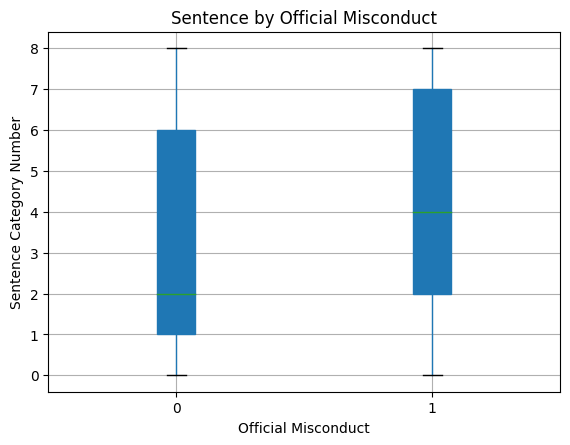

In [ ]:
#Visualizing the distribution of Sentence_Category_Number for levels of Official Misconduct
#Value of 0 means Official Misconduct did not occur in a case, value of 1 means that it did occur in a case
#Higher values indicate harsher sentences

df.boxplot(column="Sentence_Category_Number", by="OM_Binary", patch_artist = True)
plt.title("Sentence by Official Misconduct")
plt.xlabel("Official Misconduct")
plt.ylabel("Sentence Category Number")
plt.suptitle('')
plt.show()

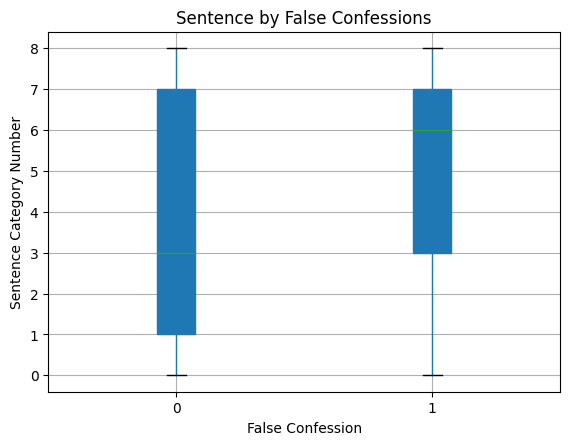

In [ ]:
#Visualizing the distribution of Sentence_Category_Number for levels of False Confession
#Value of 0 means a False Confession did not occur in a case, value of 1 means that it did occur in a case
#Higher values indicate harsher sentences

df.boxplot(column="Sentence_Category_Number", by="FC_Binary", patch_artist = True)
plt.title("Sentence by False Confessions")
plt.xlabel("False Confession")
plt.ylabel("Sentence Category Number")
plt.suptitle('')
plt.show()

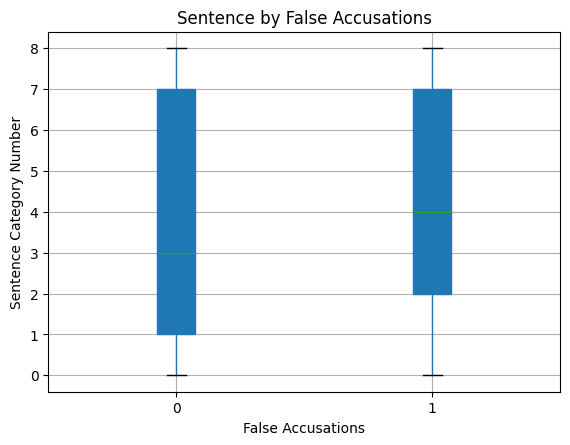

In [ ]:
#Visualizing the distribution of Sentence_Category_Number for levels of False Accusation
#Value of 0 means a False Accusation did not occur in a case, value of 1 means that it did occur in a case
#Higher values indicate harsher sentences

df.boxplot(column="Sentence_Category_Number", by="PFA_Binary", patch_artist = True)
plt.title("Sentence by False Accusations")
plt.xlabel("False Accusations")
plt.ylabel("Sentence Category Number")
plt.suptitle('')
plt.show()

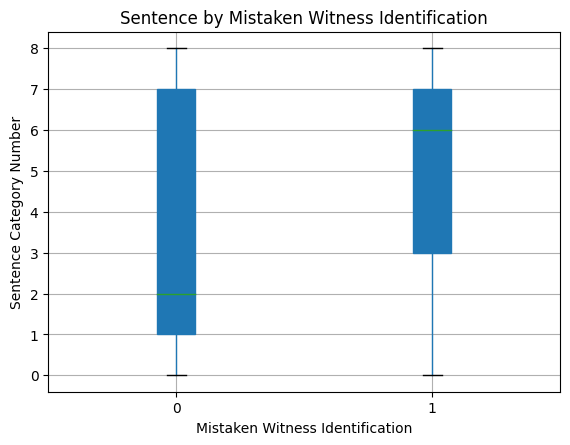

In [ ]:
#Visualizing the distribution of Sentence_Category_Number for levels of Mistaken Witness Identification
#Value of 0 means Mistaken Witness Idetification did not occur in a case, value of 1 means that it did occur in a case
#Higher values indicate harsher sentences

df.boxplot(column="Sentence_Category_Number", by="MWID_Binary", patch_artist = True)
plt.title("Sentence by Mistaken Witness Identification")
plt.xlabel("Mistaken Witness Identification")
plt.ylabel("Sentence Category Number")
plt.suptitle('')
plt.show()

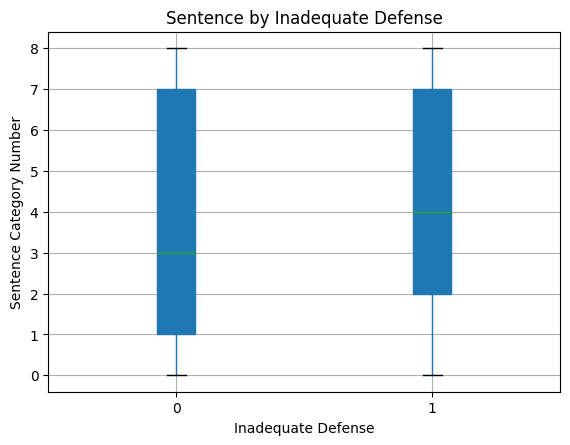

In [ ]:
#Visualizing the distribution of Sentence_Category_Number for levels of Inadequate Defense
#Value of 0 means Inadequate Defense did not occur in a case, value of 1 means that it did occur in a case
#Higher values indicate harsher sentences

df.boxplot(column="Sentence_Category_Number", by="ILD_Binary", patch_artist = True)
plt.title("Sentence by Inadequate Defense")
plt.xlabel("Inadequate Defense")
plt.ylabel("Sentence Category Number")
plt.suptitle('')
plt.show()

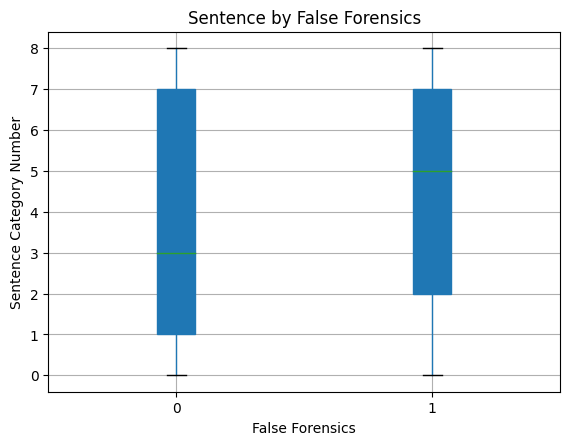

In [ ]:
#Visualizing the distribution of Sentence_Category_Number for levels of False Forensic Analysis
#Value of 0 means False Forensic Analysis did not occur in a case, value of 1 means that it did occur in a case
#Higher values indicate harsher sentences

df.boxplot(column="Sentence_Category_Number", by="FMFE_Binary", patch_artist = True)
plt.title("Sentence by False Forensics")
plt.xlabel("False Forensics")
plt.ylabel("Sentence Category Number")
plt.suptitle('')
plt.show()

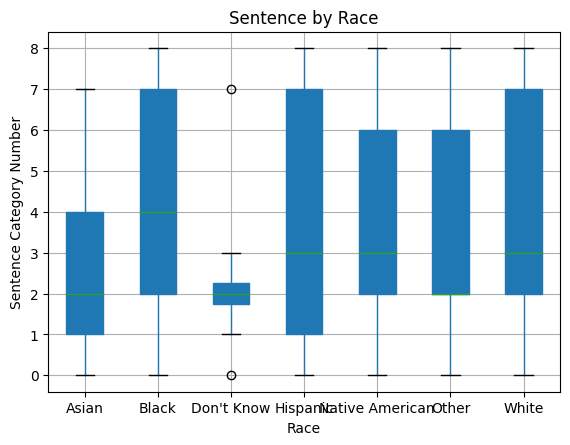

In [ ]:
#Visualizing the distribution of Sentence_Category_Number per Race

df.boxplot(column="Sentence_Category_Number", by="Race", patch_artist = True)
plt.title("Sentence by Race")
plt.xlabel("Race")
plt.ylabel("Sentence Category Number")
plt.suptitle('')
plt.show()

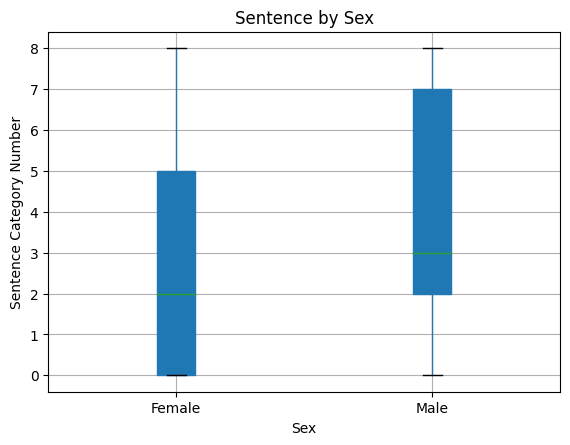

In [ ]:
#Visualizing the distribution of Sentence_Category_Number per Sex

df.boxplot(column="Sentence_Category_Number", by="Sex", patch_artist = True)
plt.title("Sentence by Sex")
plt.xlabel("Sex")
plt.ylabel("Sentence Category Number")
plt.suptitle('')
plt.show()

# Feed Forward Neural Network

In [ ]:
#Creating the labels for the regression ("Time_Spent_In_Prison_log") and classification ("Sentence_Category_Number") outputs

target_reg = df_dnn["Time_Spent_In_Prison_log"]
target_class = df_dnn["Sentence_Category_Number"]

#Splitting training and testing (for regression and classification outputs) data with an 80% / 20% split

X_train, X_test, y_train_regression, y_test_regression, y_train_classification, y_test_classification = train_test_split(
    df_dnn.drop(columns=["Time_Spent_In_Prison_log", "Sentence_Category_Number"]),
    target_reg,
    target_class,
    test_size=0.2,
    random_state=42)

In [ ]:
#Creating the 9 inputs for the model

inputs_dnn = {
    "State":
        tf.keras.layers.Input(
            shape=(1,),
            dtype=tf.float32,
            name="State"),
    "Race":
        tf.keras.layers.Input(
            shape=(1,),
            dtype=tf.float32,
            name="Race"),
    "Sex":
        tf.keras.layers.Input(
            shape=(1,),
            dtype=tf.float32,
            name="Sex"),
    "OM_Binary":
        tf.keras.layers.Input(
            shape=(1,),
            dtype=tf.float32,
            name="OM_Binary"),
    "FC_Binary":
        tf.keras.layers.Input(
            shape=(1,),
            dtype=tf.float32,
            name="FC_Binary"),
    "PFA_Binary":
        tf.keras.layers.Input(
            shape=(1,),
            dtype=tf.float32,
            name="PFA_Binary"),
    "ILD_Binary":
        tf.keras.layers.Input(
            shape=(1,),
            dtype=tf.float32,
            name="ILD_Binary"),
    "FMFE_Binary":
        tf.keras.layers.Input(
            shape=(1,),
            dtype=tf.float32,
            name="FMFE_Binary"),
    "MWID_Binary":
        tf.keras.layers.Input(
            shape=(1,),
            dtype=tf.float32,
            name="MWID_Binary")
}

In [ ]:
#Normalizing the State and Race inputs

State = tf.keras.layers.Normalization(
    name="normalization_State",
    axis=None)
State.adapt(X_train["State"])
State = State(inputs_dnn.get("State"))

Race = tf.keras.layers.Normalization(
    name="normalization_Race",
    axis=None)
Race.adapt(X_train["Race"])
Race = Race(inputs_dnn.get("Race"))

#Creating objects for the remaining inputs

OM_Binary = inputs_dnn["OM_Binary"]
FC_Binary = inputs_dnn["FC_Binary"]
PFA_Binary = inputs_dnn["PFA_Binary"]
MWID_Binary = inputs_dnn["MWID_Binary"]
ILD_Binary = inputs_dnn["ILD_Binary"]
FMFE_Binary = inputs_dnn["FMFE_Binary"]
Sex = inputs_dnn["Sex"]

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [ ]:
#Combining inputs into preprocessing layers

preprocessing_layers = tf.keras.layers.Concatenate()([
    State, Race, Sex, OM_Binary, FC_Binary, PFA_Binary, MWID_Binary, ILD_Binary, FMFE_Binary
])

In [ ]:
#Creating the framework for the regression component of the model
#2 hidden layers (25, 12 units, relu activation) and 1 output layer (1 unit, linear activation)

dense_output_reg = tf.keras.layers.Dense(
    units=25,
    activation="relu",
    name="hidden_dense_layer_1_reg")(preprocessing_layers)

dense_output_reg = tf.keras.layers.Dense(
    units=12,
    activation="relu",
    name="hidden_dense_layer_2_reg")(dense_output_reg)

regression_output = tf.keras.layers.Dense(
    units=1,
    activation="linear",
    name="regression_output")(dense_output_reg)

In [ ]:
#Creating the framework for the classification component of the model
#2 hidden layers (20, 15 units, relu activation) and 1 output layer (1 unit, softmax activation)

dense_output_class = tf.keras.layers.Dense(
    units=20,
    activation="relu",
    name="hidden_dense_layer_1_class")(preprocessing_layers)

dense_output_class = tf.keras.layers.Dense(
    units=15,
    activation="relu",
    name="hidden_dense_layer_2_class")(dense_output_class)

classification_output = tf.keras.layers.Dense(
    units=len(df_dnn["Sentence_Category_Number"].unique()),
    activation="softmax",
    name='classification_output')(dense_output_class)

In [ ]:
#Creating the model structure with the inputs and labels

dnn_model = tf.keras.Model(inputs=inputs_dnn, outputs=[regression_output, classification_output])
dnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss={"regression_output": "mean_squared_error", "classification_output": "sparse_categorical_crossentropy"},
    metrics={"regression_output": tf.keras.metrics.MeanSquaredError(), "classification_output": tf.keras.metrics.SparseCategoricalAccuracy()}
)

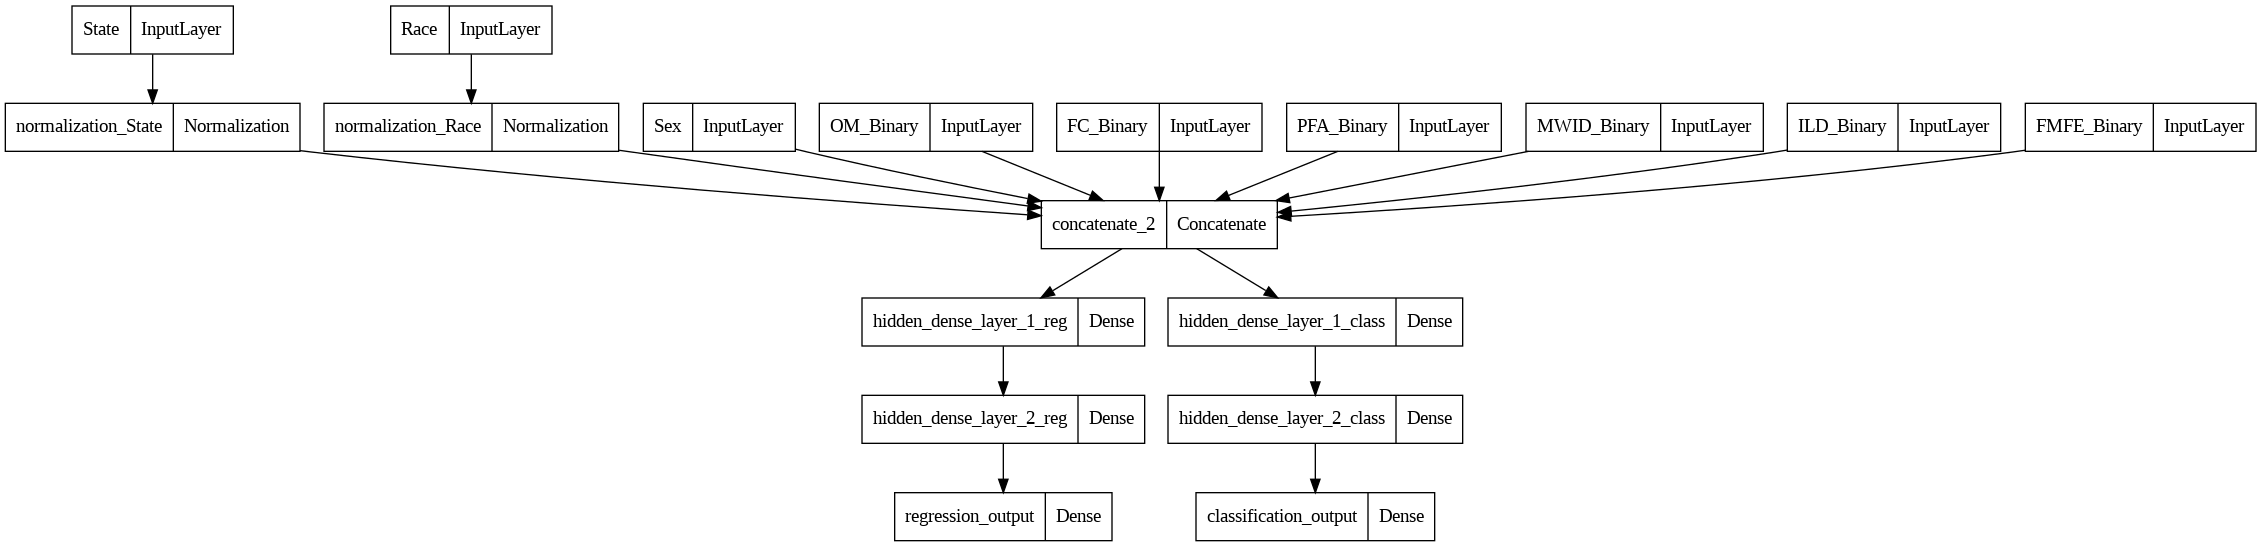

In [ ]:
#Visualizing the model

tf.keras.utils.plot_model(dnn_model)

In [ ]:
#Running the model with 14 epochs, a batch size of 100, and a validation split of 80% / 20%

tf.config.run_functions_eagerly(True)

history = dnn_model.fit(
    {name:np.array(value) for name, value in X_train.items()},
    {"regression_output": np.array(y_train_regression), "classification_output": np.array(y_train_classification)},
    epochs=14,
    batch_size=100,
    shuffle=True,
    validation_split=0.2
)

epochs = history.epoch
hist = pd.DataFrame(history.history)
mse = hist["regression_output_mean_squared_error"]
classification_accuracy = hist["classification_output_sparse_categorical_accuracy"]

Epoch 1/14
22/22 [==============================] - 2s 70ms/step - loss: 4.0317 - regression_output_loss: 1.9677 - classification_output_loss: 2.0640 - regression_output_mean_squared_error: 1.9677 - classification_output_sparse_categorical_accuracy: 0.2494 - val_loss: 2.9060 - val_regression_output_loss: 0.9398 - val_classification_output_loss: 1.9662 - val_regression_output_mean_squared_error: 0.9398 - val_classification_output_sparse_categorical_accuracy: 0.2756
Epoch 2/14
22/22 [==============================] - 1s 67ms/step - loss: 2.8382 - regression_output_loss: 0.8725 - classification_output_loss: 1.9657 - regression_output_mean_squared_error: 0.8725 - classification_output_sparse_categorical_accuracy: 0.2737 - val_loss: 2.7472 - val_regression_output_loss: 0.8265 - val_classification_output_loss: 1.9207 - val_regression_output_mean_squared_error: 0.8265 - val_classification_output_sparse_categorical_accuracy: 0.3333
Epoch 3/14
22/22 [==============================] - 2s 70ms/st

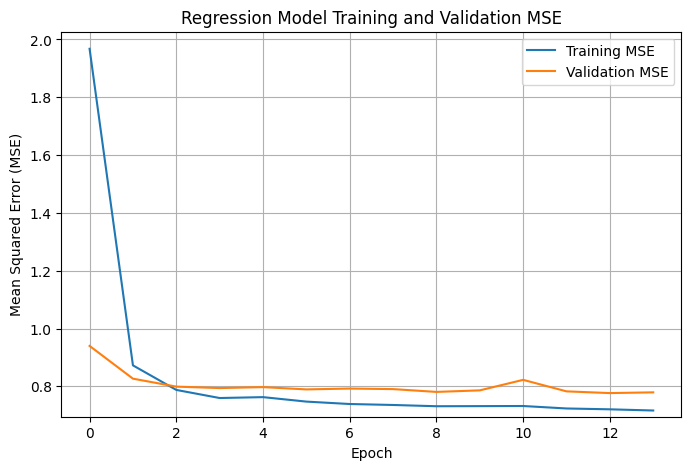

In [ ]:
#Plotting the training and validation MSE of the model

plt.figure(figsize=(8, 5))
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")

plt.plot(epochs, mse, label="Training MSE")
plt.plot(epochs, history.history["val_regression_output_mean_squared_error"], label="Validation MSE")

merged_mse_lists = mse.tolist() + history.history["val_regression_output_mean_squared_error"]
highest_mse = max(merged_mse_lists)
lowest_mse = min(merged_mse_lists)
top_of_y_axis = highest_mse * 1.03
bottom_of_y_axis = lowest_mse * 0.97

plt.ylim([bottom_of_y_axis, top_of_y_axis])
plt.legend()
plt.title("Regression Model Training and Validation MSE")
plt.grid(True)
plt.show()

In [ ]:
#Calculating the corrected RMSE for the validation

mse_final = mse[len(epochs) - 1]
rmse = math.sqrt(mse_final)
rmse_corrected = np.exp(rmse) + .01
rmse_corrected

2.341153534099033

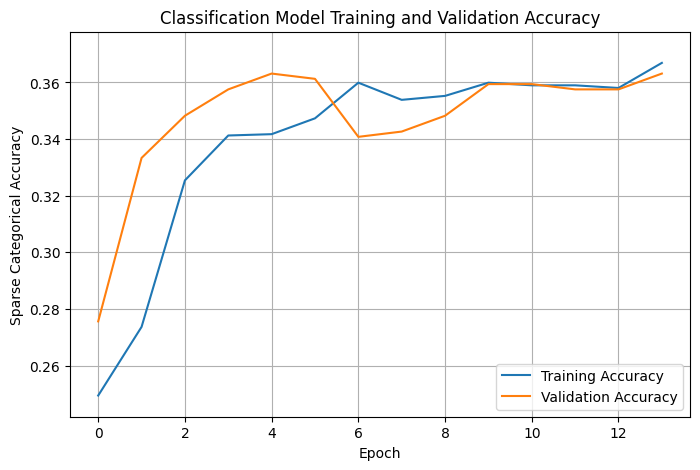

In [ ]:
#Plotting the classification accuracy of the model

plt.figure(figsize=(8, 5))
plt.xlabel("Epoch")
plt.ylabel("Sparse Categorical Accuracy")

plt.plot(epochs, classification_accuracy, label="Training Accuracy")
plt.plot(epochs, history.history["val_classification_output_sparse_categorical_accuracy"], label="Validation Accuracy")

merged_acc_lists = classification_accuracy.tolist() + history.history["val_classification_output_sparse_categorical_accuracy"]
highest_acc = max(merged_acc_lists)
lowest_acc = min(merged_acc_lists)
top_of_y_axis_acc = highest_acc * 1.03
bottom_of_y_axis_acc = lowest_acc * 0.97

plt.ylim([bottom_of_y_axis_acc, top_of_y_axis_acc])
plt.legend()
plt.title("Classification Model Training and Validation Accuracy")
plt.grid(True)
plt.show()

In [ ]:
#Creating a dictionary for the testing predictions of the model

inputs = {name: X_test[name].values for name in X_test.columns}
predictions = dnn_model.predict(inputs)

predicted_regression = predictions[0]
predicted_classification = predictions[1]

predicted_classification = dict((idx, pred) for idx, pred in enumerate(predicted_classification))

21/21 [==============================] - 0s 10ms/step


In [ ]:
#Creating a list of the top two classification predictions for each row

top_two_classifications = []

percentage_lists = list(predicted_classification.values())

for index, percentages in enumerate(percentage_lists):
    sorted_percentages = sorted(enumerate(percentages), key=lambda x: x[1], reverse=True)
    top_two_indexes = [sorted_percentages[0][0], sorted_percentages[1][0]]
    top_two_classifications.append(top_two_indexes)

classification_prediction_df = y_test_classification.to_frame().reset_index()

#Creating a dataframe with the actual sentence category, the primary prediction, and the secondary prediction

classification_columns = pd.DataFrame(top_two_classifications, columns=["Classification_1", "Classification_2"])
classification_prediction_df = pd.concat([classification_prediction_df, classification_columns], axis=1)

classification_prediction_df

#Creating a new column for determining if the model was correct or incorrect for each row

def compare_predictions(row):
    actual = row["Sentence_Category_Number"]
    top_predicted = row["Classification_1"]
    secondary_predicted = row["Classification_2"]
    if actual == top_predicted:
        return "Correct"
    elif actual == secondary_predicted:
        return "Correct"
    else:
        return "Incorrect"

classification_prediction_df["Prediction_Accuracy"] = classification_prediction_df.apply(compare_predictions, axis=1)

In [ ]:
#Analyzing the classification testing accuracy of the model

classification_prediction_df["Prediction_Accuracy"].value_counts()

Prediction_Accuracy
Correct      366
Incorrect    305
Name: count, dtype: int64

In [ ]:
#Calculating the classification testing accuracy in a percentage

correct = (classification_prediction_df["Prediction_Accuracy"] == "Correct").sum()
incorrect = (classification_prediction_df["Prediction_Accuracy"] == "Incorrect").sum()
correct / (correct + incorrect) * 100

54.54545454545454

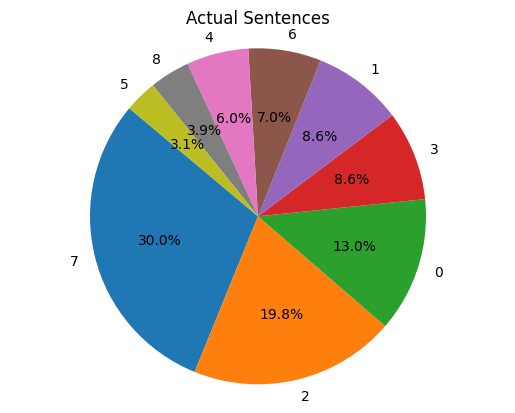

Sentence_Category_Number
7    201
2    133
0     87
3     58
1     58
6     47
4     40
8     26
5     21
Name: count, dtype: int64

In [ ]:
#Visualizing the distribution of the actual sentence lengths

value_counts = classification_prediction_df["Sentence_Category_Number"].value_counts()
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis("equal")
plt.title("Actual Sentences")
plt.show()

value_counts

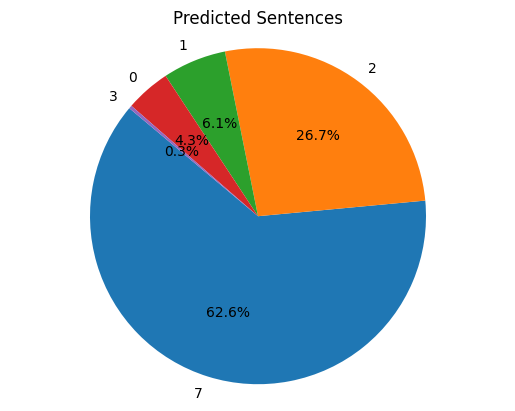

Classification_1
7    420
2    179
1     41
0     29
3      2
Name: count, dtype: int64

In [ ]:
#Visualizing the distribution of the sentence length predictions

value_counts = classification_prediction_df["Classification_1"].value_counts()
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis("equal")
plt.title("Predicted Sentences")
plt.show()

value_counts

In [ ]:
#Creating a list of the regression testing predictions (corrected)

regression_predictions_exp = []

for i in range(len(predicted_regression)):
  value = predicted_regression[i]
  value = np.exp(value) - .01
  regression_predictions_exp.append(value[0])

In [ ]:
#Creating a dataframe combining the regression testing predictions with the actual time spent in prison

regression_prediction_df = y_test_regression.to_frame().reset_index()

regression_prediction_df["Time_Spent_In_Prison"] = np.exp(regression_prediction_df["Time_Spent_In_Prison_log"])

regression_column = pd.DataFrame(regression_predictions_exp)
regression_prediction_df = pd.concat([regression_prediction_df, regression_column], axis=1)

#Creating a column calculating the absolute difference of each prediction compared to the actual value

regression_prediction_df["Difference"] = abs(regression_prediction_df["Time_Spent_In_Prison"] - regression_prediction_df[0])

#Calculating the mean absolute difference of the regression testing predictions

regression_prediction_df["Difference"].mean()

6.825897180554408

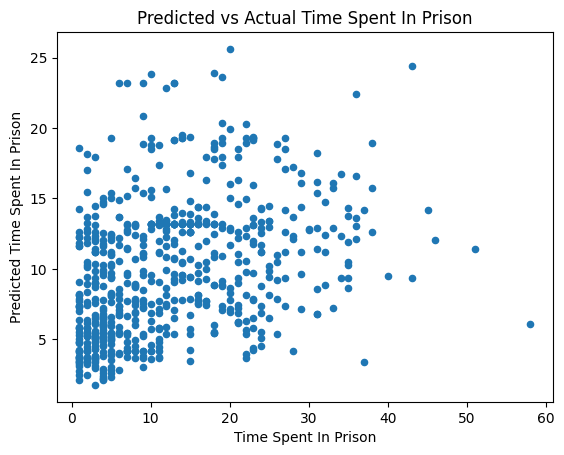

In [ ]:
#Visualizing the regression testing predictions against the actual testing values for time spent in prison

regression_prediction_df.plot.scatter(x="Time_Spent_In_Prison", y=0)
plt.xlabel("Time Spent In Prison")
plt.ylabel("Predicted Time Spent In Prison")
plt.title("Predicted vs Actual Time Spent In Prison")
plt.show()